# **Forecasting Household Electricity Consumption**

In [1]:
pip install pandas

In [2]:
pip install numpy

In [3]:
from google.colab import files
uploaded = files.upload()

Saving household_power_consumption.txt to household_power_consumption.txt


# 1. Loading and Preparing Dataset

In [4]:
# load and clean-up data
from numpy import nan
from numpy import isnan
from pandas import read_csv
from pandas import to_numeric

# fill missing values with a value at the same time one day ago
def fill_missing(values):
	one_day = 60 * 24
	for row in range(values.shape[0]):
		for col in range(values.shape[1]):
			if isnan(values[row, col]):
				values[row, col] = values[row - one_day, col]

# load all data
dataset = read_csv('household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
# mark all missing values
dataset.replace('?', nan, inplace=True)
# make dataset numeric
dataset = dataset.astype('float32')
# fill missing
fill_missing(dataset.values)
# add a column for for the remainder of sub metering
values = dataset.values
dataset['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])
# save updated dataset
dataset.to_csv('household_power_consumption.csv')

#2. Model Evaluation


2(a). *Problem Framing*

In [5]:
# resample minute data to total for each day
from pandas import read_csv
# load the new file
dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# resample data to daily
daily_groups = dataset.resample('D')
daily_data = daily_groups.sum()
# summarize
print(daily_data.shape)
print(daily_data.head())
# save
daily_data.to_csv('household_power_consumption_days.csv')

(1442, 8)
            Global_active_power  ...  sub_metering_4
datetime                         ...                
2006-12-16             1209.176  ...    14680.933319
2006-12-17             3390.460  ...    36946.666732
2006-12-18             2203.826  ...    19028.433281
2006-12-19             1666.194  ...    13131.900043
2006-12-20             2225.748  ...    20384.800011

[5 rows x 8 columns]


2(b). *Evaluation Metric*

In [6]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

2(c). *Train and Test Sets*

In [9]:
# split into standard weeks
from numpy import split
from numpy import array
from pandas import read_csv

# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test

# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
train, test = split_dataset(dataset.values)
# validate train data
print(train.shape)
print(train[0, 0, 0], train[-1, -1, 0])
# validate test
print(test.shape)
print(test[0, 0, 0], test[-1, -1, 0])

(159, 7, 8)
3390.46 1309.2679999999998
(46, 7, 8)
2083.4539999999984 2197.006000000004


*2(d) Walk Foward Validation*

In [10]:
# evaluate a single model
def evaluate_model(model_func, train, test):
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = model_func(history)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	predictions = array(predictions)
	# evaluate predictions days for each week
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

In [11]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# 3. Naive Forecast Models

daily: [511.886] 452.9, 596.4, 532.1, 490.5, 534.3, 481.5, 482.0
weekly: [469.389] 567.6, 500.3, 411.2, 466.1, 471.9, 358.3, 482.0
week-oya: [465.294] 550.0, 446.7, 398.6, 487.0, 459.3, 313.5, 555.1


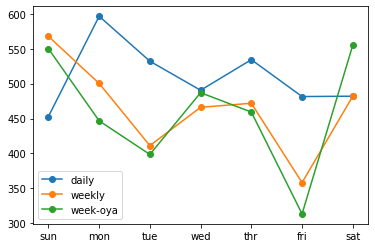

In [20]:
# naive forecast strategies
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# evaluate a single model
def evaluate_model(model_func, train, test):
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = model_func(history)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	predictions = array(predictions)
	# evaluate predictions days for each week
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

# daily persistence model
def daily_persistence(history):
	# get the data for the prior week
	last_week = history[-1]
	# get the total active power for the last day
	value = last_week[-1, 0]
	# prepare 7 day forecast
	forecast = [value for _ in range(7)]
	return forecast

# weekly persistence model
def weekly_persistence(history):
	# get the data for the prior week
	last_week = history[-1]
	return last_week[:, 0]

# week one year ago persistence model
def week_one_year_ago_persistence(history):
	# get the data for the prior week
	last_week = history[-52]
	return last_week[:, 0]

# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# define the names and functions for the models we wish to evaluate
models = dict()
models['daily'] = daily_persistence
models['weekly'] = weekly_persistence
models['week-oya'] = week_one_year_ago_persistence
# evaluate each model
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
for name, func in models.items():
	# evaluate and get scores
	score, scores = evaluate_model(func, train, test)
	# summarize scores
	summarize_scores(name, score, scores)
	# plot scores
	pyplot.plot(days, scores, marker='o', label=name)
# show plot
pyplot.legend()
pyplot.show()